In [11]:
[None] * 11

[None, None, None, None, None, None, None, None, None, None, None]

In [2]:
import  pathlib
import os
import numpy as np

file_counting = 0

import pathlib
parent_dir = pathlib.Path('__file__').parent.resolve()
trainingdata_dir = os.path.join(parent_dir, "inputs/trainingdata")

for file in os.listdir(trainingdata_dir):
    if file.startswith('data_to_train'):
        file_counting += 1

print('total training filecount: {}'.format(file_counting))


data = [None] * file_counting
data_length = [0] * file_counting

for i in range(0, file_counting):
    with open(os.path.join(trainingdata_dir, 'data_to_train') + '_' + str(i) + '.csv', 'r') as fh:
        data[i] = np.loadtxt(fh, delimiter=',')
        data_length[i] = len(data[i])

print('Load Data Finished')
print('Total Data Set: {}'.format(np.sum(data_length)))



total training filecount: 14
Load Data Finished
Total Data Set: 873206


In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.nn as nn
from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

class VehicleForwardFeedNNModel(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        layers = [nn.Linear(in_c,128),nn.LeakyReLU(), nn.Linear(128,256),nn.LeakyReLU(), nn.Linear(256,out_c)]
        self.layers = nn.Sequential(*layers)

    def forward(self,x):
        x = self.layers(x)
        return x

input_shape = 10
output_shape = 5
input_timesteps = 5
ratio = 0.2

total_length = np.sum(data_length) - input_timesteps*file_counting

data_train = np.zeros((total_length * input_timesteps, input_shape))
data_labels = np.zeros((total_length, output_shape))

current_idx = 0

for u in range(0, file_counting):
    data_labels[current_idx:current_idx + len(data[u]) - input_timesteps] = (data[u])[input_timesteps:, 0:output_shape]

    for pp in range(0, len(data[u]) - input_timesteps):
        idx = input_timesteps * current_idx + pp * input_timesteps
        data_train[idx:idx + input_timesteps, :] = (data[u])[pp:pp + input_timesteps, :]

    current_idx += ((len(data[u]) - input_timesteps))

data_train = np.reshape(data_train, (len(data_labels), input_timesteps * input_shape))

#shuffle data
indices = np.arange(data_train.shape[0])
np.random.shuffle(indices)
data_labels = data_labels[indices]
data_train = data_train[indices]
#data_train = np.reshape(data_train[indices], (len(data_labels) * input_timesteps, input_shape))

#split data
p = int(len(data_train) * (1 - ratio))
mod = p % 5
p = p - mod

train_x = data_train[:p, :]
train_y = data_labels[:p,:]

#scale data
print('USE STANDARD SCALER')
x_scalers = StandardScaler()  # with_mean=True, with_std=True
x_scalers = x_scalers.fit(train_x)

y_scalers = StandardScaler()  # with_mean=True, with_std=True
y_scalers = y_scalers.fit(train_y)

train_x = x_scalers.transform(train_x)
train_y = y_scalers.transform(train_y)

test_x = x_scalers.transform(data_train[p:, :])
test_y = y_scalers.transform(data_labels[p:, :])

train_x = torch.Tensor(train_x) # transform to torch tensor
train_y = torch.Tensor(train_y)
test_x = torch.Tensor(test_x) # transform to torch tensor
test_y = torch.Tensor(test_y)

train_dataset = TensorDataset(train_x,train_y) # create your datset
train_dataloader = DataLoader(train_dataset,batch_size=8) # create your dataloader

print('CREATE FEEDFORWARD NEURAL NETWORK')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VehicleForwardFeedNNModel(input_timesteps*input_shape,output_shape).to(device)

criterion = MSELoss()
optimizer = torch.optim.Adam(model.parameters())

#optimizer = Adam(model.parameters())
#criterion = nn.CrossEntropyLoss()

# enumerate epochs
for epoch in range(100):
    # enumerate mini batches
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for (inputs, targets) in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            inputs, targets = inputs.to(device), targets.to(device)
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
            tepoch.set_postfix(loss=loss.item())


USE STANDARD SCALER
CREATE FEEDFORWARD NEURAL NETWORK


Epoch 0:   2%|▏         | 1456/87314 [00:02<02:37, 544.63batch/s, loss=0.00523]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 0:   4%|▍         | 3401/87314 [00:06<02:33, 548.15batch/s, loss=0.00633]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 0:   6%|▌         | 5387/87314 [00:09<02:29, 549.55batch/s, loss=0.00613]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to a

KeyboardInterrupt: 

In [26]:
from torchvision import transforms
a = np.random.random([4,3])
a
int_scaler = StandardScaler()  # with_mean=True, with_std=True
scalers = int_scaler.fit(a)

a_fit = scalers.transform(a)

print(a)
print(scalers)
print(a_fit)


a_torch = torch.tensor(a)
b = torch.nn.functional.normalize(a_torch,dim=0)
print(b)


[[0.2605624  0.45907186 0.3693466 ]
 [0.34781689 0.00700307 0.12708097]
 [0.33539508 0.83053931 0.95353962]
 [0.79314912 0.81806551 0.86729575]]
StandardScaler()
[[-0.82741749 -0.20707497 -0.61151635]
 [-0.4117065  -1.5521141  -1.31709337]
 [-0.47088835  0.89815116  1.08989365]
 [ 1.71001234  0.8610379   0.83871607]]
tensor([[0.2701, 0.3664, 0.2742],
        [0.3606, 0.0056, 0.0944],
        [0.3477, 0.6629, 0.7080],
        [0.8223, 0.6529, 0.6439]], dtype=torch.float64)


In [34]:
a = [None]*2
a[0] = np.array([[1,2],[3,4]])
a[1] = np.array([[5,2],[3,4]])
b = np.concatenate(a,axis=0)
c=[0,1]
d=[1]
b[c,d]

array([2, 4])

In [36]:
parent_dir = pathlib.Path('__file__').parent.resolve()
os.path.join(parent_dir, 'output','model_name')

'/home/lab/Documents/project/nn_model/output/model_name'

In [37]:
from acsr_vehicle import *
from acsr_run import *
model_name = 'output/models/trained'
if not os.path.exists(model_name):
    print('No trained model found')
    exit
model = VehicleFeedForwardModel(10*2, 2)
model.load_state_dict(torch.load(model_name))

targets,predicted = run_model(model)
targets=targets.detach().numpy()
predicted = predicted.detach().numpy()


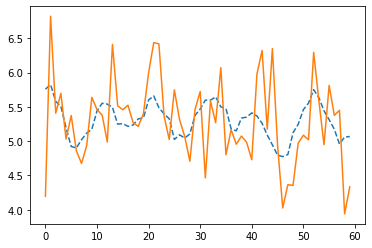

In [47]:
plt.plot(targets[80:140,0],'--')
plt.plot(predicted[80:140,0])
plt.show()